In [3]:
! pip install deap
! pip install japanize_matplotlib
import random
from deap import base, creator, tools
from deap.benchmarks import rosenbrock
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import threading
tf.test.gpu_device_name()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'/device:GPU:0'

In [4]:
import math
import random

from itertools import repeat

try:
    from collections.abc import Sequence
except ImportError:
    from collections import Sequence

def mutUniformFloat(individual, low, up, indpb): #tools.mutUniformIntをfloat型に対応

    size = len(individual)
    if not isinstance(low, Sequence):
        low = repeat(low, size)
    elif len(low) < size:
        raise IndexError("low must be at least the size of individual: %d < %d" % (len(low), size))
    if not isinstance(up, Sequence):
        up = repeat(up, size)
    elif len(up) < size:
        raise IndexError("up must be at least the size of individual: %d < %d" % (len(up), size))

    for i, xl, xu in zip(range(size), low, up):
        if random.random() < indpb:
            individual[i] = random.uniform(xl, xu)
    return individual,

In [5]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

toolbox.register("attr_gene", random.uniform, -2.048, 2.048)
# 各個体は50変数分の遺伝子を持つ
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_gene, 50)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
# rosenbrock関数でインポート
toolbox.register("evaluate", rosenbrock)
toolbox.register("mate", tools.cxBlend)
toolbox.register("mutate", mutUniformFloat, low = -2.048, up = 2.048)
toolbox.register("select", tools.selTournament)

In [6]:
import os

thread_num = 4 #CPUスレッド数
thread2_num = 8 #GPUスレッド数

flag_list = [-1 for qq in range(thread_num + thread2_num)]

def main(ng, ps, cx, mp, al, ea, ts, tit, seed, flag, th_num):

    #並列処理に使用
    flag2 = seed*27+flag
    if (flag2 in flag_list): return
    else: flag_list[th_num] = flag2

    fname = "/content/drive/My Drive/google_notebook/rosenblock/" + tit + ".csv" 
    if(os.path.exists(fname) == False):


      random.seed(seed)

      # GAパラメータ
      N_GEN = ng      # 繰り返し世代数
      POP_SIZE = ps  # 集団内の個体数
      CX_PB = cx     # 交叉発生確率
      MUT_PB = mp     # 変異確率
      alpha = al #各変数が交叉する確率
      eta = ea #各変数が突然変異する確率
      tournsize = ts #トーナメントサイズ(ts個から1個最適なものを選ぶ)

      bi_list = []

      # 個体集団の生成
      pop = toolbox.population(n=POP_SIZE)

      # 個体集団の適応度の評価
      fitnesses = list(map(toolbox.evaluate, pop))
      for ind, fit in zip(pop, fitnesses):
          ind.fitness.values = fit

      # 適応度の抽出
      fits = [ind.fitness.values[0] for ind in pop]
      best_ind = tools.selBest(pop, 1)[0]
      bi_list.append(best_ind[0])

      # 進化ループ開始
      g = 0
      scores = []
      while g < N_GEN:

          g = g + 1

          # 次世代個体の選択・複製
          offspring = toolbox.select(pop, len(pop), tournsize=tournsize)
          offspring = list(map(toolbox.clone, offspring))

      # 交叉
          for child1, child2 in zip(offspring[::2], offspring[1::2]):

              # 交叉させる個体を選択
              if random.random() < CX_PB:
                  toolbox.mate(child1, child2, alpha=alpha)

                  # 交叉させた個体は適応度を削除する
                  del child1.fitness.values
                  del child2.fitness.values

          # 変異
          for mutant in offspring:

              # 変異させる個体を選択
              if random.random() < MUT_PB:
                  toolbox.mutate(mutant, indpb=eta)

                  # 変異させた個体は適応度を削除する
                  del mutant.fitness.values

          # 適応度を削除した個体について適応度の再評価を行う
          invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
          fitnesses = map(toolbox.evaluate, invalid_ind)
          for ind, fit in zip(invalid_ind, fitnesses):
              ind.fitness.values = fit

          # 個体集団を新世代個体集団で更新
          pop[:] = offspring

          # 新世代の全個体の適応度の抽出
          fits = [ind.fitness.values[0] for ind in pop]

          # 適応度の統計情報の出力
          length = len(pop)
          mean = sum(fits) / length
          sum2 = sum(x*x for x in fits)
          std = abs(sum2 / length - mean**2)**0.5

          scores.append(min(fits))

          if ((g%100 == 0) and (g < 500)):
            best_ind = tools.selBest(pop, 1)[0]
            bi_list.append(best_ind[0])

      # 最良個体の抽出
      best_ind = tools.selBest(pop, 1)[0]
      bi_list.append(best_ind[0])

      f2 = scores

      bi_list2 = []
      for biyo in bi_list:
        if (biyo >= 0.5 and biyo < 1.5): bi_list2.append(1)
        else: bi_list2.append(0)
      f3 = bi_list2

      with open(fname, 'w') as f:
        f.write("score movement,x values\n")
        for ii in range(6):
          f.write(str(f2[ii]) + "," + str(round(f3[ii])) + "\n")
        for ii in range(4, len(f2)):
          f.write(str(f2[ii]) + ",\n")

    flag_list[th_num] = -1

In [7]:
def train(th_num):
  for ii in range(50):
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=3, tit = "base_"+ str(ii),seed=ii,flag=0,th_num=th_num)
    main(ng=500,ps=1000,cx=0.4,mp=0.0,al=0.1,ea=0.1,ts=3, tit ="CX_0_"+ str(ii),seed=ii,flag=1,th_num=th_num) #変異なし
    main(ng=500,ps=1000,cx=0.4,mp=0.2,al=0.1,ea=0.1,ts=3, tit ="CX_1_"+ str(ii),seed=ii,flag=2,th_num=th_num) #変異0.2
    main(ng=500,ps=1000,cx=0.4,mp=0.6,al=0.1,ea=0.1,ts=3, tit ="CX_2_"+ str(ii),seed=ii,flag=3,th_num=th_num) #変異0.6
    main(ng=500,ps=1000,cx=0.4,mp=0.8,al=0.1,ea=0.1,ts=3, tit ="CX_3_"+ str(ii),seed=ii,flag=4,th_num=th_num) #変異0.8
    main(ng=500,ps=1000,cx=0.4,mp=1.0,al=0.1,ea=0.1,ts=3, tit ="CX_4_"+ str(ii),seed=ii,flag=5,th_num=th_num) #変異最大

    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.025,ts=3, tit ="ALPHA_0_"+ str(ii),seed=ii,flag=6,th_num=th_num) #変数変異確率0.025
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.05,ts=3, tit ="ALPHA_1_"+ str(ii),seed=ii,flag=7,th_num=th_num) #変数変異確率0.05
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.2,ts=3, tit ="ALPHA_2_"+ str(ii),seed=ii,flag=8,th_num=th_num) #変数変異確率0.2
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.4,ts=3, tit ="ALPHA_3_"+ str(ii),seed=ii,flag=9,th_num=th_num) #変数変異確率0.4

    main(ng=500,ps=1000,cx=0.0,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="MUT_0_"+ str(ii),seed=ii,flag=10,th_num=th_num) #交叉なし
    main(ng=500,ps=1000,cx=0.2,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="MUT_1_"+ str(ii),seed=ii,flag=11,th_num=th_num) #交叉0.2
    main(ng=500,ps=1000,cx=0.6,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="MUT_2_"+ str(ii),seed=ii,flag=12,th_num=th_num) #交叉0.6
    main(ng=500,ps=1000,cx=0.8,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="MUT_3_"+ str(ii),seed=ii,flag=13,th_num=th_num) #交叉0.8
    main(ng=500,ps=1000,cx=1.0,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="MUT_4_"+ str(ii),seed=ii,flag=14,th_num=th_num) #交叉最大

    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.025,ea=0.1,ts=3, tit ="ETA_0_"+ str(ii),seed=ii,flag=15,th_num=th_num) #変数交叉確率0.025
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.05,ea=0.1,ts=3, tit ="ETA_1_"+ str(ii),seed=ii,flag=16,th_num=th_num) #変数交叉確率0.05
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.2,ea=0.1,ts=3, tit ="ETA_2_"+ str(ii),seed=ii,flag=17,th_num=th_num) #変数交叉確率0.2
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.4,ea=0.1,ts=3, tit ="ETA_3_"+ str(ii),seed=ii,flag=18,th_num=th_num) #変数交叉確率0.4

    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=1, tit ="ts_0_"+ str(ii),seed=ii,flag=19,th_num=th_num) #トーナメントサイズ1
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=2, tit ="ts_1_"+ str(ii),seed=ii,flag=20,th_num=th_num) #トーナメントサイズ2
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=4, tit ="ts_2_"+ str(ii),seed=ii,flag=21,th_num=th_num) #トーナメントサイズ4
    main(ng=500,ps=1000,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=5, tit ="ts_3_"+ str(ii),seed=ii,flag=22,th_num=th_num) #トーナメントサイズ5

    main(ng=500,ps=250,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="POP_down0_"+ str(ii),seed=ii,flag=23,th_num=th_num) #個体数4分の一
    main(ng=500,ps=500,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="POP_down_"+ str(ii),seed=ii,flag=24,th_num=th_num) #個体数半減
    main(ng=500,ps=2000,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="POP_up_"+ str(ii),seed=ii,flag=25,th_num=th_num) #個体数2倍
    main(ng=500,ps=5000,cx=0.4,mp=0.4,al=0.1,ea=0.1,ts=3, tit ="POP_up2_"+ str(ii),seed=ii,flag=26,th_num=th_num) #個体数5倍

In [8]:
import time

thread_list = []
with tf.device('/cpu:0'):
  for i in range(thread_num):
      thread = threading.Thread(target=train, args=(i,))
      thread.start()
      thread_list.append(thread)
      print(i)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

with tf.device('/gpu:0'):
  for i2 in range(thread_num, thread_num + thread2_num):
      mp = threading.Thread(target=train, args=(i2,))
      mp.start()
      thread_list.append(thread)
      print(i2)
      sleep_seconds = 1
      time.sleep(sleep_seconds)

while(True):
  print('\r', end='')
  print(flag_list, end='')
  sleep_seconds = 3
  time.sleep(sleep_seconds)

for thread in thread_list:
    thread.join()

0
1
2
3
4
5
6
7
8
9
10
11
[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]

KeyboardInterrupt: ignored

In [9]:
import pandas as pd

def div_50(n):
    return n/50

pd_score = []
pd_x = []
fname = ["base","CX_0","CX_1","CX_2","CX_3","CX_4","ALPHA_0","ALPHA_1","ALPHA_2","ALPHA_3","MUT_0","MUT_1","MUT_2","MUT_3","MUT_4","ETA_0","ETA_1","ETA_2","ETA_3","ts_0","ts_1","ts_2","ts_3","POP_down0","POP_down","POP_up","POP_up2"]

for ii in range(len(fname)):
  print(ii)
  ps_k = [0 for bb in range(500)]
  px_k = [0 for bb in range(5)]
  for jj in range(50):
    kari = pd.read_csv("/content/drive/My Drive/google_notebook/rosenblock/" + fname[ii] + "_" + str(jj) + ".csv")
    ss = kari["score movement"].dropna().values.tolist()
    xx = kari["x values"].dropna().values.tolist()
    ps_k = [x + y for (x, y) in zip(ss, ps_k)]
    px_k = [x + y for (x, y) in zip(xx, px_k)]
  ps_k2 = list(map(div_50,ps_k))
  px_k2 = list(map(div_50,px_k))
  pd_score.append(ps_k2)
  pd_x.append(px_k2)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
 
# 折れ線グラフを出力
score_yoko = np.array([ii for ii in range(500)])
x_yoko = np.array([ii*100 for ii in range(5)])

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


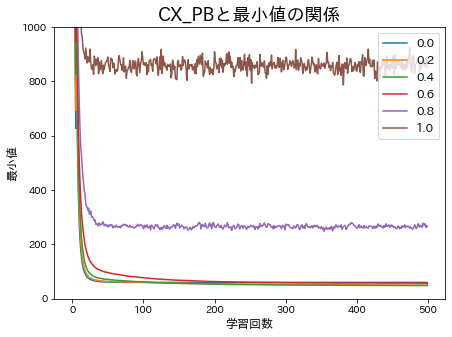

In [11]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[1], label="0.0")
ax.plot(score_yoko, pd_score[2], label="0.2")
ax.plot(score_yoko, pd_score[0], label="0.4")
ax.plot(score_yoko, pd_score[3], label="0.6")
ax.plot(score_yoko, pd_score[4], label="0.8")
ax.plot(score_yoko, pd_score[5], label="1.0")
ax.set_ylim(0, 1000)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("CX_PBと最小値の関係",fontsize=18) # タイトル
plt.show()

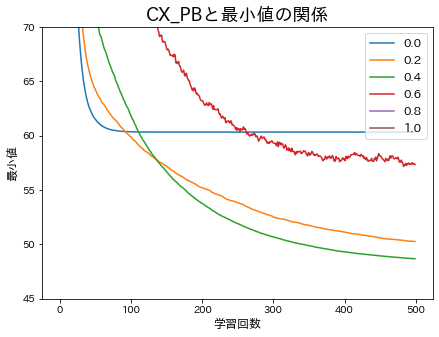

In [12]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[1], label="0.0")
ax.plot(score_yoko, pd_score[2], label="0.2")
ax.plot(score_yoko, pd_score[0], label="0.4")
ax.plot(score_yoko, pd_score[3], label="0.6")
ax.plot(score_yoko, pd_score[4], label="0.8")
ax.plot(score_yoko, pd_score[5], label="1.0")
ax.set_ylim(45, 70)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("CX_PBと最小値の関係",fontsize=18) # タイトル
plt.show()

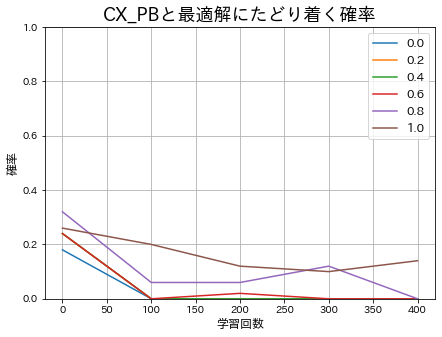

In [28]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[1], label="0.0")
ax.plot(x_yoko, pd_x[2], label="0.2")
ax.plot(x_yoko, pd_x[0], label="0.4")
ax.plot(x_yoko, pd_x[3], label="0.6")
ax.plot(x_yoko, pd_x[4], label="0.8")
ax.plot(x_yoko, pd_x[5], label="1.0")
ax.set_ylim(0.0,1.0)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("CX_PBと最適解にたどり着く確率",fontsize=18) # タイトル
ax.grid()
plt.show()

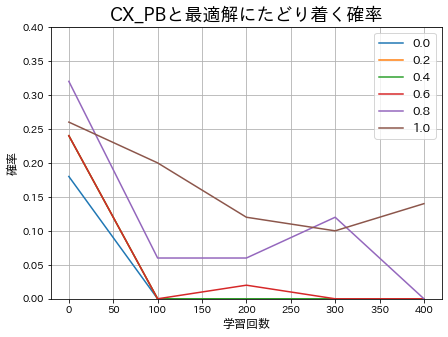

In [29]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[1], label="0.0")
ax.plot(x_yoko, pd_x[0], label="0.2")
ax.plot(x_yoko, pd_x[2], label="0.4")
ax.plot(x_yoko, pd_x[3], label="0.6")
ax.plot(x_yoko, pd_x[4], label="0.8")
ax.plot(x_yoko, pd_x[5], label="1.0")
ax.set_ylim(0.0, 0.4)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("CX_PBと最適解にたどり着く確率",fontsize=18) # タイトル
ax.grid()
plt.show()

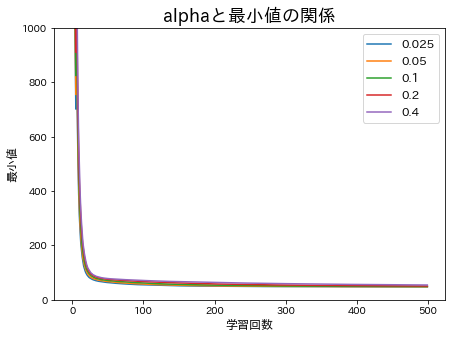

In [16]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[6], label="0.025")
ax.plot(score_yoko, pd_score[7], label="0.05")
ax.plot(score_yoko, pd_score[0], label="0.1")
ax.plot(score_yoko, pd_score[8], label="0.2")
ax.plot(score_yoko, pd_score[9], label="0.4")
ax.set_ylim(0, 1000)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("alphaと最小値の関係",fontsize=18) # タイトル
plt.show()

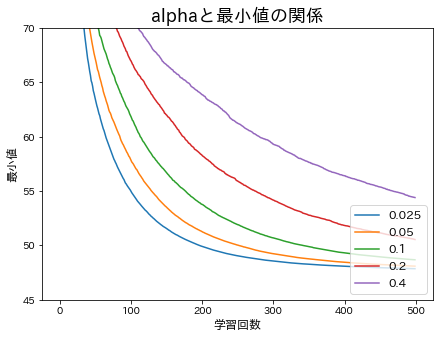

In [40]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[6], label="0.025")
ax.plot(score_yoko, pd_score[7], label="0.05")
ax.plot(score_yoko, pd_score[0], label="0.1")
ax.plot(score_yoko, pd_score[8], label="0.2")
ax.plot(score_yoko, pd_score[9], label="0.4")
ax.set_ylim(45, 70)
ax.legend(loc="lower right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("alphaと最小値の関係",fontsize=18) # タイトル
plt.show()

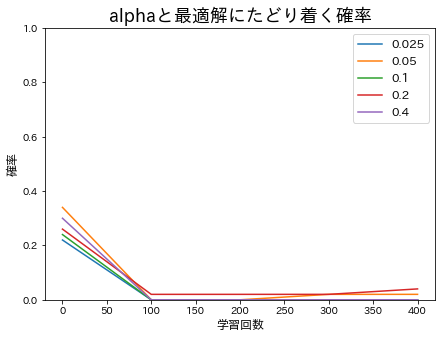

In [23]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[6], label="0.025")
ax.plot(x_yoko, pd_x[7], label="0.05")
ax.plot(x_yoko, pd_x[0], label="0.1")
ax.plot(x_yoko, pd_x[8], label="0.2")
ax.plot(x_yoko, pd_x[9], label="0.4")
ax.set_ylim(0, 1)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("alphaと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()

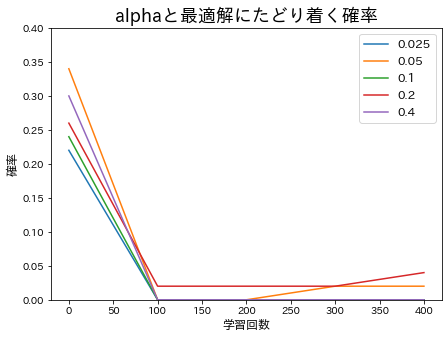

In [24]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[6], label="0.025")
ax.plot(x_yoko, pd_x[7], label="0.05")
ax.plot(x_yoko, pd_x[0], label="0.1")
ax.plot(x_yoko, pd_x[8], label="0.2")
ax.plot(x_yoko, pd_x[9], label="0.4")
ax.set_ylim(0, 0.4)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("alphaと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()

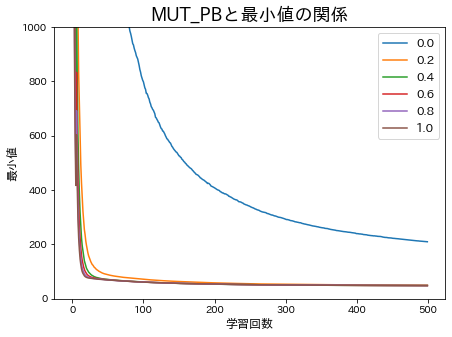

In [25]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[10], label="0.0")
ax.plot(score_yoko, pd_score[11], label="0.2")
ax.plot(score_yoko, pd_score[0], label="0.4")
ax.plot(score_yoko, pd_score[12], label="0.6")
ax.plot(score_yoko, pd_score[13], label="0.8")
ax.plot(score_yoko, pd_score[14], label="1.0")
ax.set_ylim(0, 1000)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("MUT_PBと最小値の関係",fontsize=18) # タイトル
plt.show()

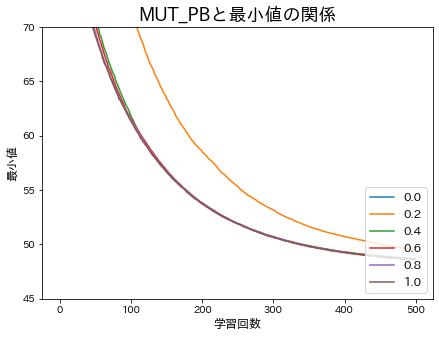

In [41]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[10], label="0.0")
ax.plot(score_yoko, pd_score[11], label="0.2")
ax.plot(score_yoko, pd_score[0], label="0.4")
ax.plot(score_yoko, pd_score[12], label="0.6")
ax.plot(score_yoko, pd_score[13], label="0.8")
ax.plot(score_yoko, pd_score[14], label="1.0")
ax.set_ylim(45, 70)
ax.legend(loc="lower right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("MUT_PBと最小値の関係",fontsize=18) # タイトル
plt.show()

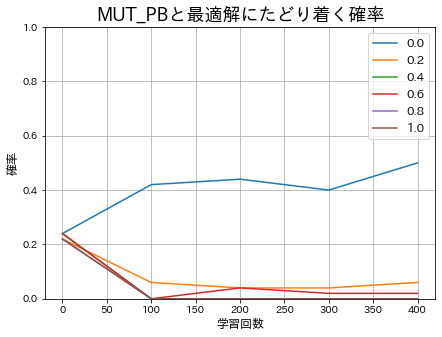

In [30]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[10], label="0.0")
ax.plot(x_yoko, pd_x[11], label="0.2")
ax.plot(x_yoko, pd_x[0], label="0.4")
ax.plot(x_yoko, pd_x[12], label="0.6")
ax.plot(x_yoko, pd_x[13], label="0.8")
ax.plot(x_yoko, pd_x[14], label="1.0")
ax.set_ylim(0.0,1.0)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("MUT_PBと最適解にたどり着く確率",fontsize=18) # タイトル
ax.grid()
plt.show()

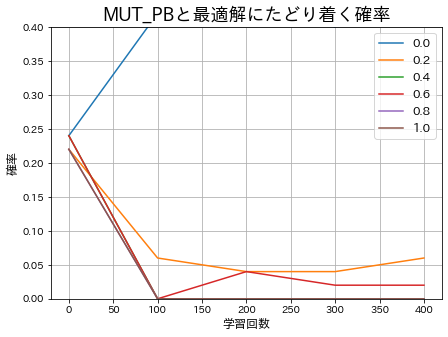

In [31]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[10], label="0.0")
ax.plot(x_yoko, pd_x[11], label="0.2")
ax.plot(x_yoko, pd_x[0], label="0.4")
ax.plot(x_yoko, pd_x[12], label="0.6")
ax.plot(x_yoko, pd_x[13], label="0.8")
ax.plot(x_yoko, pd_x[14], label="1.0")
ax.set_ylim(0.0,0.4)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("MUT_PBと最適解にたどり着く確率",fontsize=18) # タイトル
ax.grid()
plt.show()

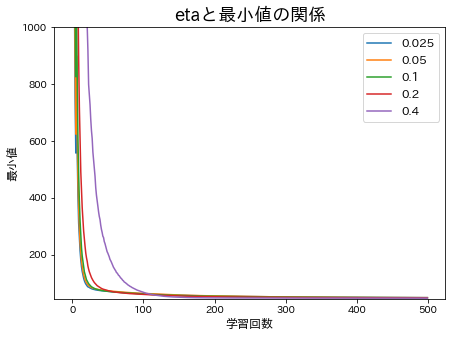

In [42]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[15], label="0.025")
ax.plot(score_yoko, pd_score[16], label="0.05")
ax.plot(score_yoko, pd_score[0], label="0.1")
ax.plot(score_yoko, pd_score[17], label="0.2")
ax.plot(score_yoko, pd_score[18], label="0.4")
ax.set_ylim(45, 1000)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("etaと最小値の関係",fontsize=18) # タイトル
plt.show()

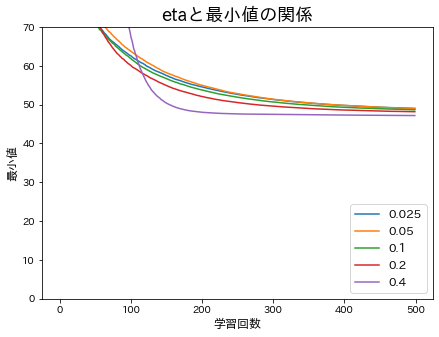

In [34]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[15], label="0.025")
ax.plot(score_yoko, pd_score[16], label="0.05")
ax.plot(score_yoko, pd_score[0], label="0.1")
ax.plot(score_yoko, pd_score[17], label="0.2")
ax.plot(score_yoko, pd_score[18], label="0.4")
ax.set_ylim(0, 70)
ax.legend(loc="lower right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("etaと最小値の関係",fontsize=18) # タイトル
plt.show()

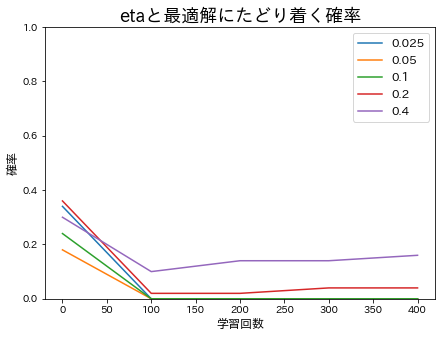

In [35]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[15], label="0.025")
ax.plot(x_yoko, pd_x[16], label="0.05")
ax.plot(x_yoko, pd_x[0], label="0.1")
ax.plot(x_yoko, pd_x[17], label="0.2")
ax.plot(x_yoko, pd_x[18], label="0.4")
ax.set_ylim(0, 1)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("etaと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()

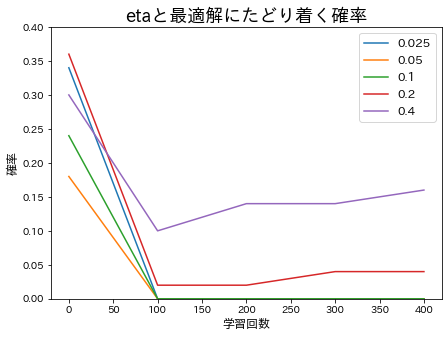

In [37]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[15], label="0.025")
ax.plot(x_yoko, pd_x[16], label="0.05")
ax.plot(x_yoko, pd_x[0], label="0.1")
ax.plot(x_yoko, pd_x[17], label="0.2")
ax.plot(x_yoko, pd_x[18], label="0.4")
ax.set_ylim(0, 0.4)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("etaと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()

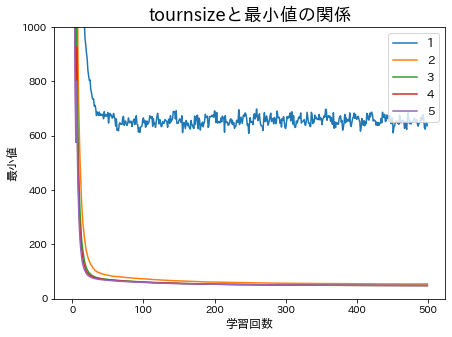

In [46]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[19], label="1")
ax.plot(score_yoko, pd_score[20], label="2")
ax.plot(score_yoko, pd_score[0], label="3")
ax.plot(score_yoko, pd_score[21], label="4")
ax.plot(score_yoko, pd_score[22], label="5")
ax.set_ylim(0, 1000)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("tournsizeと最小値の関係",fontsize=18) # タイトル
plt.show()

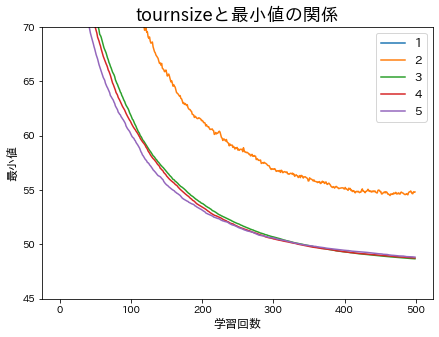

In [45]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[19], label="1")
ax.plot(score_yoko, pd_score[20], label="2")
ax.plot(score_yoko, pd_score[0], label="3")
ax.plot(score_yoko, pd_score[21], label="4")
ax.plot(score_yoko, pd_score[22], label="5")
ax.set_ylim(45, 70)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("tournsizeと最小値の関係",fontsize=18) # タイトル
plt.show()

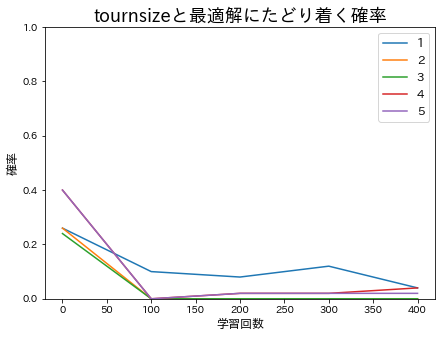

In [44]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[19], label="1")
ax.plot(x_yoko, pd_x[20], label="2")
ax.plot(x_yoko, pd_x[0], label="3")
ax.plot(x_yoko, pd_x[21], label="4")
ax.plot(x_yoko, pd_x[22], label="5")
ax.set_ylim(0, 1)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("tournsizeと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()

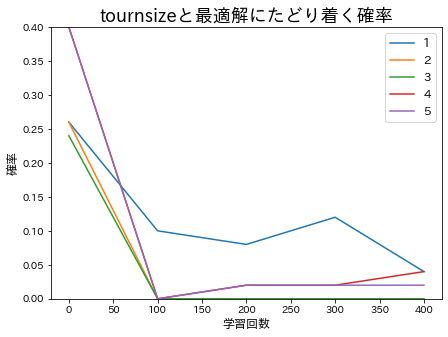

In [47]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[19], label="1")
ax.plot(x_yoko, pd_x[20], label="2")
ax.plot(x_yoko, pd_x[0], label="3")
ax.plot(x_yoko, pd_x[21], label="4")
ax.plot(x_yoko, pd_x[22], label="5")
ax.set_ylim(0, 0.4)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("tournsizeと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()

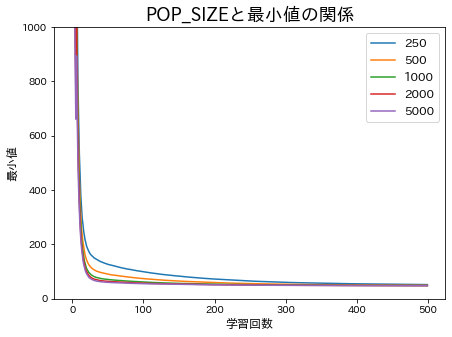

In [48]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[23], label="250")
ax.plot(score_yoko, pd_score[24], label="500")
ax.plot(score_yoko, pd_score[0], label="1000")
ax.plot(score_yoko, pd_score[25], label="2000")
ax.plot(score_yoko, pd_score[26], label="5000")
ax.set_ylim(0, 1000)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("POP_SIZEと最小値の関係",fontsize=18) # タイトル
plt.show()

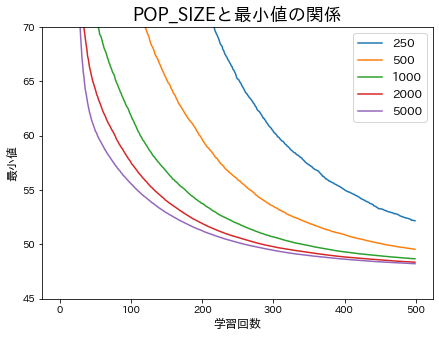

In [49]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(score_yoko, pd_score[23], label="250")
ax.plot(score_yoko, pd_score[24], label="500")
ax.plot(score_yoko, pd_score[0], label="1000")
ax.plot(score_yoko, pd_score[25], label="2000")
ax.plot(score_yoko, pd_score[26], label="5000")
ax.set_ylim(45, 70)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("最小値", fontsize=12)
ax.set_title("POP_SIZEと最小値の関係",fontsize=18) # タイトル
plt.show()

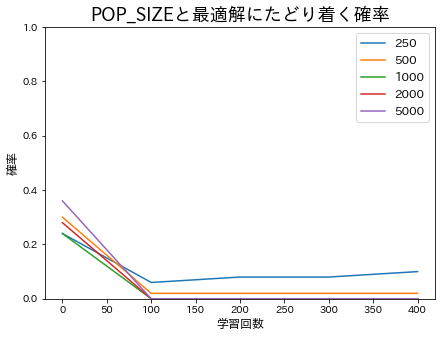

In [50]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[23], label="250")
ax.plot(x_yoko, pd_x[24], label="500")
ax.plot(x_yoko, pd_x[0], label="1000")
ax.plot(x_yoko, pd_x[25], label="2000")
ax.plot(x_yoko, pd_x[26], label="5000")
ax.set_ylim(0, 1)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("POP_SIZEと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()

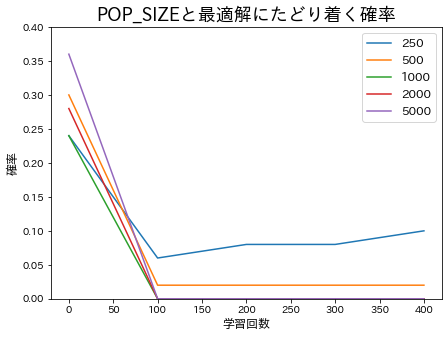

In [51]:
fig, ax = plt.subplots(figsize=(7, 5), facecolor="w")
ax.plot(x_yoko, pd_x[23], label="250")
ax.plot(x_yoko, pd_x[24], label="500")
ax.plot(x_yoko, pd_x[0], label="1000")
ax.plot(x_yoko, pd_x[25], label="2000")
ax.plot(x_yoko, pd_x[26], label="5000")
ax.set_ylim(0, 0.4)
ax.legend(loc="upper right", fontsize=12)
ax.set_xlabel("学習回数", fontsize=12)
ax.set_ylabel("確率", fontsize=12)
ax.set_title("POP_SIZEと最適解にたどり着く確率",fontsize=18) # タイトル
plt.show()